# Japan Graph Construction Story

This notebook visualizes the unique challenges of the Japanese dataset, specifically the **disconnection between Station Platforms and Rail Lines**, and how we solve it.

**The Challenge:**
In the MLIT dataset, 'Stations' are represented as platform polygons, and 'Railroads' are lines. They often do not touch. If we naively build a graph, stations would be floating islands.

**The Solution:**
1.  **Group Platforms**: Merge individual platform polygons into a single 'Station' centroid.
2.  **Merge Interchanges**: Combine stations that share physical space (different lines/operators).
3.  **Spatial Snapping**: Snap rail endpoints to the nearest station centroid if within ~20cm.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
from shapely.geometry import box

# Add project root to path to import src modules
project_root = Path("..").resolve()
sys.path.append(str(project_root))

# Create maps directory
os.makedirs("maps/japan", exist_ok=True)

from src.processing.japan import load_data, group_stations, create_initial_nodes, merge_interchange_stations, build_graph
from src.processing import create_folium_map, plot_connected_components, create_component_map

## 1. Load Data & Focus on Tokyo
We load the full dataset but will zoom in on Tokyo for visualization.

In [2]:
base_dir = "../datasets/japan"
gdf_stations, gdf_railroads = load_data(base_dir)

# Filter for Tokyo area for plotting (approx bounding box)
tokyo_bbox = box(139.7, 35.6, 139.9, 35.8)
tokyo_stations = gdf_stations[gdf_stations.intersects(tokyo_bbox)]
tokyo_rail = gdf_railroads[gdf_railroads.intersects(tokyo_bbox)]

print(f"Stations in view: {len(tokyo_stations)}")
print(f"Rail segments in view: {len(tokyo_rail)}")

Processing Japan dataset from: ../datasets/japan
Loading stations...
Loaded 10235 stations.
Loading railroad sections...


Loaded 21932 railroad sections.
Stations in view: 488
Rail segments in view: 1071


### Visualization: The Disconnect (Interactive)
Zoom in on Tokyo to see how stations (Red polygons) are physically separated from rail lines (Gray lines).

CI detected: Generating static plot for Raw Data.


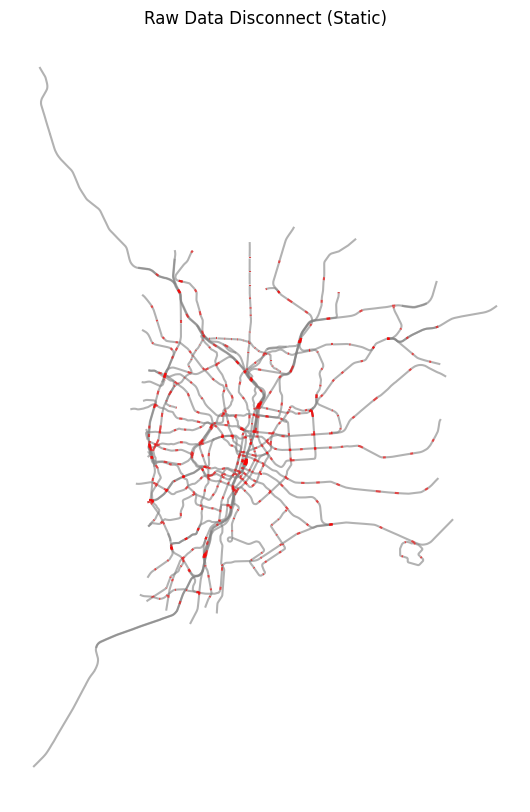

In [3]:
# Interactive Map of Raw Data
output_path = "maps/japan/japan_raw_disconnect.html"

import os
if os.environ.get('CI'):
    print("CI detected: Generating static plot for Raw Data.")
    # Use Geopandas plot for static fallback
    ax = tokyo_rail.plot(color='gray', alpha=0.6, figsize=(10,10))
    tokyo_stations.plot(ax=ax, color='red', alpha=0.6)
    plt.title('Raw Data Disconnect (Static)')
    plt.axis('off')
    plt.show()
else:
    m = tokyo_rail.explore(
        color='gray', 
        style_kwds={'weight': 2, 'opacity': 0.6}, 
        name='Rail Lines',
        tiles='CartoDB Positron'
    )

    tokyo_stations.explore(
        m=m, 
        color='red', 
        style_kwds={'fillOpacity': 0.6}, 
        name='Station Platforms'
    )
    m.save(output_path)
    print(f"Raw disconnect map saved to {output_path}")
    display(m)


## 2. Process Nodes (Group & Merge)
We run the grouping and merging logic to create single Centroids for each station.

In [4]:
group_code_groups = group_stations(gdf_stations)
station_groups = create_initial_nodes(group_code_groups)
merged_stations, coord_to_station = merge_interchange_stations(station_groups)

Step 1: Grouping station platforms...


Found 9048 unique group codes
Step 2: Creating station nodes...


Step 3: Merging interchange stations...
Merged 5 interchange groups


## 3. Build Graph (Spatial Snapping)
Now we build the graph. The `build_graph` function automatically snaps the rail endpoints to these new station centroids.

In [5]:
G = build_graph(merged_stations, coord_to_station, gdf_railroads)

print(f"Final Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Step 4: Building NetworkX graph...


Final Graph: 10357 nodes, 10952 edges


## 4. Connected Components (Before vs After)
This is the most critical check for Japan. Without spatial snapping, the network is fragmented into thousands of pieces.

Let's simulate the "Before" state (Naively connecting rails without snapping) to calculate components, and compare it to our "After" state.

In [6]:
# Simulate 'Before' Graph (Naive)
G_before = nx.Graph()
# Add nodes just from rail endpoints (no snapping)
for _, row in gdf_railroads.iterrows():
    if row.geometry.geom_type == 'LineString':
        coords = list(row.geometry.coords)
        u, v = coords[0], coords[-1]
        G_before.add_edge(u, v)

plot_connected_components(G_before, title="Before Processing (Naive Connectivity)")

### After Processing
With our snapping logic, the components merge into a massive nationwide network.

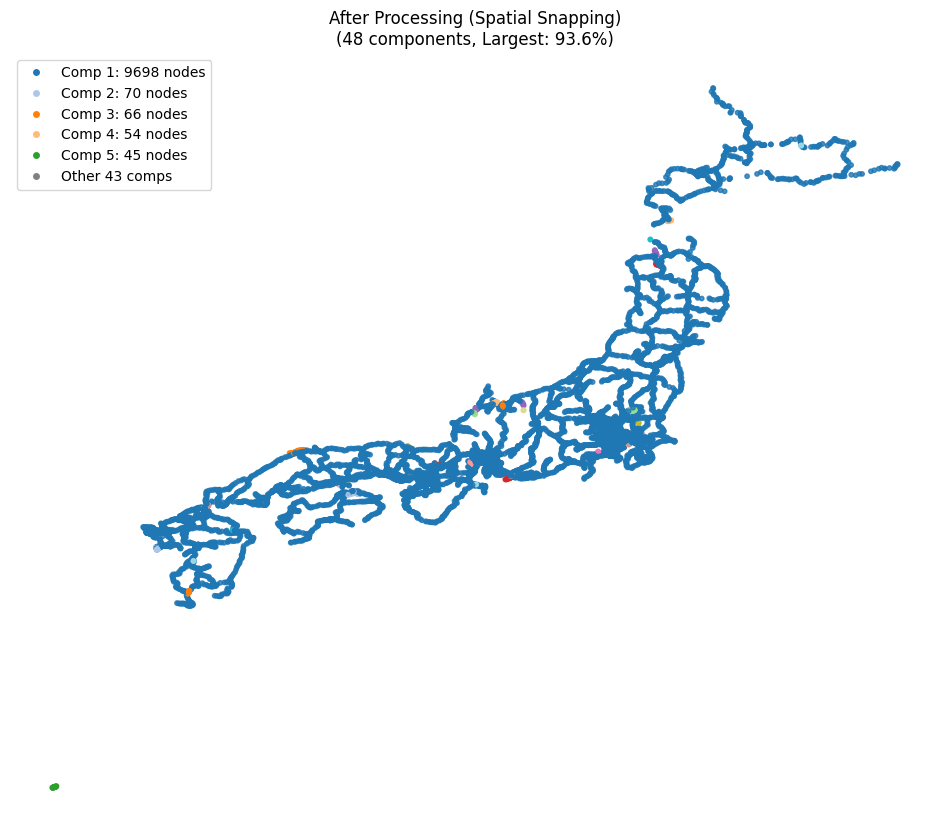

In [7]:
plot_connected_components(G, title="After Processing (Spatial Snapping)")

### Interactive Component Map
See if any islands remain.

CI detected: Generating static component map.


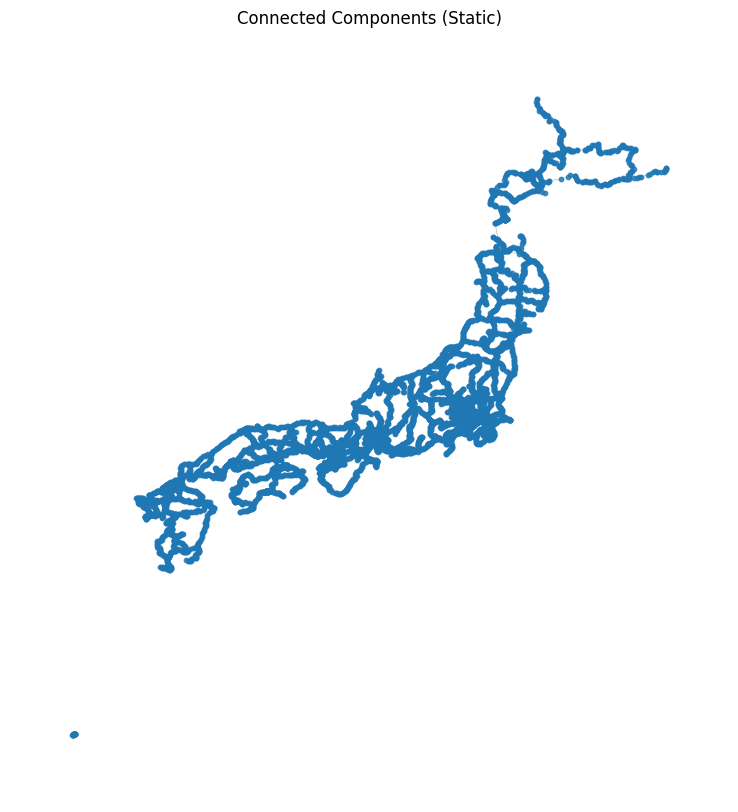

In [8]:
output_path = "maps/japan/japan_component_map.html"

import os
from src.processing.visualize import create_static_map

if os.environ.get('CI'):
    print("CI detected: Generating static component map.")
    create_static_map(G, title='Connected Components (Static)')
else:
    m = create_component_map(G)
    m.save(output_path)
    print(f"Map saved to {output_path}. If it doesn't appear below, open this file manually.")
    display(m)
